### Text Processing for Author Recognition using Spark

#### Import statements

In [266]:
import pyspark as ps    # import the spark suite
import warnings         # display warning if spark context already exists
import os
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType, FloatType
import string
from wordcloud import WordCloud, STOPWORDS
import random
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import colorsys
from pyspark.sql.functions import length
from pyspark.sql.functions import count
from PIL import Image
from pyspark.sql.functions import mean as sql_mean
from pyspark.sql.functions import count
%matplotlib inline

#### Initialized Spark Context

In [267]:
try:
    sc = ps.SparkContext('local[4]') # create spark context to work locally on all available cpus
    print('created SparkContext')
except ValueError:
    warnings.warn('SparkContext already exists')    # issue a warning if context already exists

/Users/sydneydecoto/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: SparkContext already exists


### Read data.json into Spark SQL context

In [3]:
spark = ps.SQLContext(sc)

In [4]:
data_file = 'data/data.json'
df = spark.read.json(data_file)

CONSIDER:

for fun use RDD and map reduce to remove the double bars I put into the excerpts!

In [5]:
print df.printSchema()
print df.count()
df.show(3)

root
 |-- author: string (nullable = true)
 |-- excerpt: string (nullable = true)
 |-- title: string (nullable = true)

None
9316
+--------------+--------------------+---------------+
|        author|             excerpt|          title|
+--------------+--------------------+---------------+
|CharlesDickens|﻿The Project Gute...|AChristmasCarol|
|CharlesDickens|Dickens gave his ...|AChristmasCarol|
|CharlesDickens|Dickens's greates...|AChristmasCarol|
+--------------+--------------------+---------------+
only showing top 3 rows



### Give our dataframe a SQL table name

In [6]:
df.createOrReplaceTempView("excerpts")

In [7]:
sqlDF = spark.sql("SELECT count(*) FROM excerpts WHERE author = 'MarkTwain'")
sqlDF.show()

+--------+
|count(1)|
+--------+
|    2349|
+--------+



### Lambda functions are created to explore the the character count, word count, and average word length and then add them to the dataframe.

In [268]:
def char_count(text):
    return len(text)

def word_count(text):
    return len(text.split())

def avg_word_length(text):
    return sum([len(t) for t in text.split()]) / float(len(text.split()))

def sentence_count(text):
    return len(text.split('.'))

def sentence_length(text):
    return sum([len(t.split()) for t in text.split('.')]) / float(len(text.split('.'))) 

def tokenize_excerpt(text):
    stops = set(stopwords.words('english'))  # get a set of english stop words
    unpunctuated_text = text.translate(None, string.punctuation)  # remove punctuation
    tokens = word_tokenize(unpunctuated_text)  # tokenize
    cleaned_tokens = [t.lower() for t in tokens if t.lower() not in stops]  # remove stopwords, lowercase everything
    return cleaned_tokens

def avg_word_length2(tokens):
    return sum([len(t) for t in tokens.split(' ')]) / float(len(tokens.split(' ')))

In [11]:
charcount_udf = udf(lambda x : char_count(x))
wordcount_udf = udf(lambda x: word_count(x))
avgwordlen_udf = udf(lambda x: avg_word_length(x))
sentencecount_udf = udf(lambda x: sentence_count(x))
sentencelength_udf = udf(lambda x: sentence_length(x))
tokenize_udf = udf(lambda x: tokenize_excerpt(x))
wordlen2_udf = udf(lambda x: avg_word_length2(x))

df2 = df.withColumn("character_count", charcount_udf(df.excerpt).cast(FloatType())) \
        .withColumn("word_count", wordcount_udf(df.excerpt).cast(FloatType())) \
        .withColumn("avg_wordlen", avgwordlen_udf(df.excerpt).cast(FloatType())) \
        .withColumn("sent_count", sentencecount_udf(df.excerpt).cast(FloatType())) \
        .withColumn("sent_length", sentencelength_udf(df.excerpt).cast(FloatType())) \
        .withColumn("tokenized", tokenize_udf(df.excerpt))
    
df3 = df2.withColumn("wordlen_tokens", wordlen2_udf(df.excerpt).cast(FloatType()))
df3.printSchema()

root
 |-- author: string (nullable = true)
 |-- excerpt: string (nullable = true)
 |-- title: string (nullable = true)
 |-- character_count: float (nullable = true)
 |-- word_count: float (nullable = true)
 |-- avg_wordlen: float (nullable = true)
 |-- sent_count: float (nullable = true)
 |-- sent_length: float (nullable = true)
 |-- tokenized: string (nullable = true)
 |-- wordlen_tokens: float (nullable = true)



In [12]:
df3.createOrReplaceTempView("excerpts")
sqlDF = spark.sql('''SELECT author
                    , ROUND(AVG(avg_wordlen),3) AS AvgWordLength
                    , ROUND(AVG(word_count),1) AS AvgWordsPerParagraph
                    , ROUND(AVG(sent_length),1) AS AvgWordsPerSentence
                    , ROUND(AVG(wordlen_tokens),3) AS AvgTokenizedWordLength
                    FROM excerpts GROUP BY author''')
sqlDF.show()

+--------------+-------------+--------------------+-------------------+----------------------+
|        author|AvgWordLength|AvgWordsPerParagraph|AvgWordsPerSentence|AvgTokenizedWordLength|
+--------------+-------------+--------------------+-------------------+----------------------+
|     MarkTwain|        4.474|               282.9|               24.9|                 4.478|
|      JohnMuir|        4.701|               318.5|               26.5|                 4.698|
|    JaneAusten|        4.569|               271.4|               21.8|                 4.567|
|CharlesDickens|        4.439|               246.2|               21.1|                 4.438|
+--------------+-------------+--------------------+-------------------+----------------------+



In [13]:
sqlDFTwain = spark.sql("SELECT character_count, avg_wordlen, word_count, sent_length FROM excerpts WHERE author = 'MarkTwain' AND sent_length <=100")
sqlDFMuir = spark.sql("SELECT character_count, avg_wordlen, word_count, sent_length FROM excerpts WHERE author = 'JohnMuir' AND sent_length <=100")
sqlDFAusten = spark.sql("SELECT character_count, avg_wordlen, word_count, sent_length FROM excerpts WHERE author = 'JaneAusten' AND sent_length <=100")
sqlDFDickens = spark.sql("SELECT character_count, avg_wordlen, word_count, sent_length FROM excerpts WHERE author = 'CharlesDickens' AND sent_length <=100")

In [ ]:
### Make histograms of some

In [292]:
def make_plots(DFs, col, bins, title, colors, x_lab, authors, x_lim=None, y_lim=None):
    plt.subplots(4,4,sharex=True, sharey=True, figsize=(8,8))
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.suptitle(title, fontsize=18)
    for i, DF in enumerate(DFs):
        make_hist(DF, col, bins, colors[i], x_lim, y_lim, i, x_lab, authors[i])
    
    
def make_hist(DF, col, bins, color, x_lim, y_lim, i, x_lab, author):
    # Create pandas DF of bins and counts
    test_histogram = DF.select(col).rdd.flatMap(lambda x: x).histogram(bins)
    temp_df = pd.DataFrame(zip(list(test_histogram)[0],
                                list(test_histogram)[1]),columns=['Bin','Frequency'])
    plt.subplot(2,2,i+1)
    weights = temp_df.Frequency/temp_df.Frequency.sum()  # normalize
    plt.hist(temp_df.Bin, bins, weights=weights, color=color, 
             alpha=0.8, label=author)
    # Find mean sentence length
    x_val = DF.select(sql_mean(col)).select('avg('+col+')').head()[0]
    plt.axvline(x=x_val, color=color, label="Mean")
    plt.xlabel(x_lab)
    plt.ylabel("Frequency")
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    plt.legend();

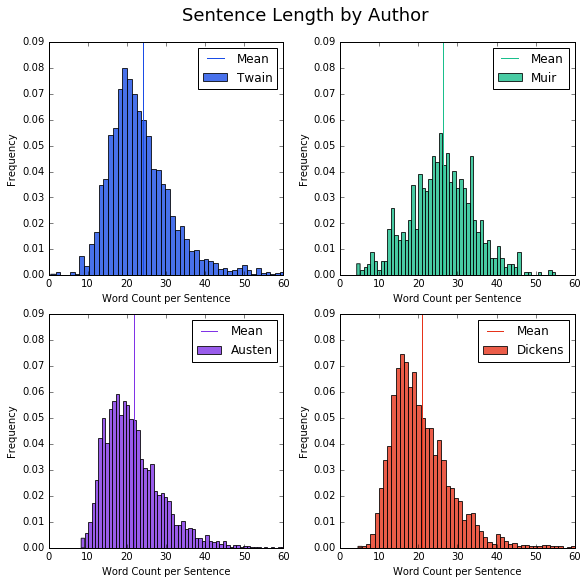

In [296]:
DFs = [sqlDFTwain, sqlDFMuir, sqlDFAusten, sqlDFDickens]
authors = ["Twain", "Muir", "Austen", "Dickens"]
colors = [[0.1, 0.3, .9], [0.1, 0.75, 0.55], [0.5, 0.2, 0.9], [0.9, 0.2, 0.1]]
# Make Sentence Length Histograms

make_plots(DFs=DFs, col='sent_length', bins=75, title='Sentence Length by Author',
           colors=colors, x_lim=(0,60), y_lim=(0, 0.09), x_lab="Word Count per Sentence", authors=authors)
# plt.savefig('./images/sent_len.png')

In [270]:
def make_text(df):
    t = df.collect()
    ft = [str(a) for a in t]
    return ' '.join(ft)

In [279]:
def make_wordcloud(text, stopwords, color_func, mask_path):
    mask = np.array(Image.open(mask_path))
    wordcloud = WordCloud(background_color='white', stopwords=stopwords, mask=mask).generate(text)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud.recolor(color_func=color_func, random_state=3))
    plt.axis("off")
    plt.show()

In [280]:
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    hsl = colorsys.rgb_to_hls(rgb[0], rgb[1], rgb[2])
    return "hsl({}, {}%, {}%)".format(int(hsl[0]*360), int(hsl[2]*100), int(hsl[1]*random.randint(40, 100)))

In [281]:
stopwords = set(STOPWORDS)
custom_stops = ['excerpt', 'row', 'u2019', 'u2019s', 'u2019t', 'u201d', 'u201c', '201', "u'",
                '201c', 'mis', 'u201ci', '201ci', "u201d'", 'said', 'one', 'xa0i', 'gutenberg']
for sw in custom_stops:
    stopwords.add(sw)

#### Make a wordcloud for Mark Twain text

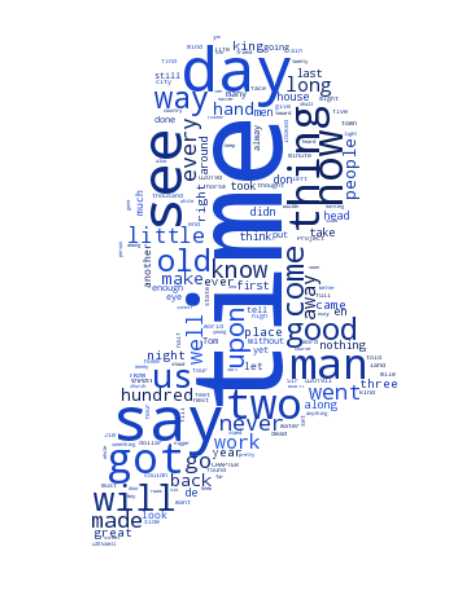

In [282]:
rgb = [0.1, 0.3, .9]
text = make_text(spark.sql('''SELECT excerpt FROM excerpts WHERE author = "MarkTwain"'''))
make_wordcloud(text, stopwords, color_func, './images/MarkTwain.jpg')

#### Make a word cloud for Jane Austen text

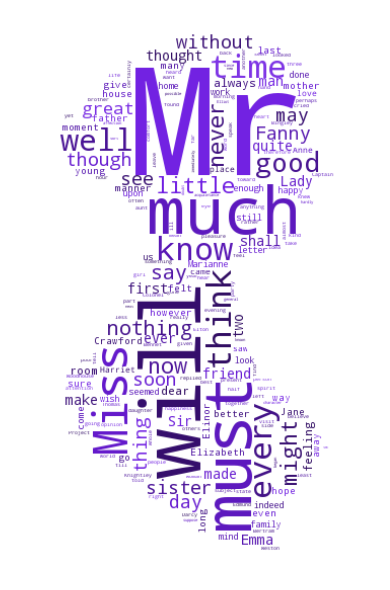

In [286]:
rgb = [0.5, 0.2, 0.9]
text = make_text(spark.sql('''SELECT excerpt FROM excerpts WHERE author = "JaneAusten"'''))
make_wordcloud(text, stopwords, color_func, './images/JaneAusten.jpg')

#### Make a wordcloud for John Muir text

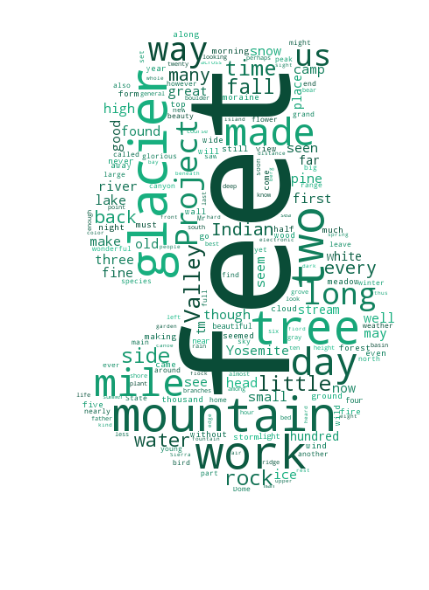

In [290]:
rgb = [0.1, 0.75, 0.55]
text = make_text(spark.sql('''SELECT excerpt FROM excerpts WHERE author = "JohnMuir"'''))
make_wordcloud(text, stopwords, color_func, './images/JohnMuir.jpg')

#### Make a wordcloud for Charles Dickens text

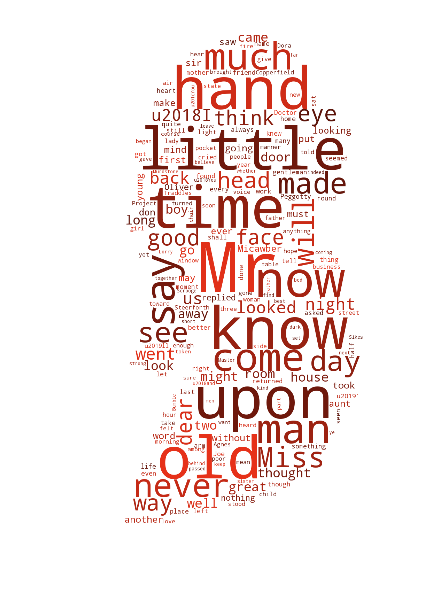

In [285]:
rgb = [0.9, 0.2, 0.1]
text = make_text(spark.sql('''SELECT excerpt FROM excerpts WHERE author = "CharlesDickens"'''))
make_wordcloud(text, stopwords, color_func, './images/CharlesDickens.jpg')